# DV2607 Project Notebook
### Authors:
### Oliver Ljung (ollj19@student.bth.se)
### Phoebe Waters (phaa19@student.bth.se)

## Importing modules and dataset

In [50]:
# imports
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Activation, BatchNormalization, LeakyReLU, Reshape, UpSampling2D, Dropout
from keras import Sequential, Model
from keras.datasets import mnist
from keras.utils import to_categorical
import keras.backend as KB

from keras.losses import BinaryCrossentropy, CategoricalCrossentropy, Hinge # Loss Classes
from keras.losses import binary_crossentropy, categorical_crossentropy, hinge # Loss functions

import random

## Defining functions

In [51]:
# Defining functions

def create_classifier():
    # Create a CNN model
    model = Sequential(name="mnist_classifier")

    # Add Convolution layers
    model.add(Conv2D(28, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))

    model.add(Flatten())

    # Add predictive layers
    model.add(Dense(56, activation='relu'))
    model.add(Dense(10, activation='softmax', name="classication_output"))
    
    print(model.summary())

    # Add input
    input = Input(shape = (28,28,1))

    # Get ouput from model
    prediction = model(input)

    return model
    return Model(input, prediction)

def create_generator():
    # Create a CNN model
    model = Sequential(name="generator")

    model.add(Dense(7*7*28, activation='relu', input_dim=100))
    model.add(Reshape((7,7,28)))

    model.add(UpSampling2D())
    model.add(Conv2D(28, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())

    model.add(UpSampling2D())
    model.add(Conv2D(56, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())
    
    model.add(Conv2D(1, (3,3), activation='relu', padding="same"))
    model.add(Activation('tanh', name="image_output"))

    print(model.summary())

    input = Input(shape = (100))
    
    img = model(input)
    
    return model
    return Model(input, img)

def create_adv_generator():
    # Create a CNN model
    model = Sequential(name="adv_generator")

    model.add(Conv2D(28, (3,3), activation='relu', padding="same", input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(28, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())

    model.add(UpSampling2D())
    model.add(Conv2D(56, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())
    
    model.add(Conv2D(1, (3,3), activation='relu', padding="same"))
    model.add(Activation('tanh', name="adv_image_output"))

    print(model.summary())

    input = Input(shape = (28,28,1))
    
    img = model(input)
    
    return model
    return Model(input, img)

def create_discriminator():
    # Create a CNN model
    model = Sequential(name="discriminator")

    # Add Convolution layers
    model.add(Conv2D(28, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))

    model.add(Flatten())

    # Add predictive layers
    model.add(Dense(56, activation='relu'))
    model.add(Dense(1, activation='sigmoid', name="validity_output"))
    
    print(model.summary())

    # Add input
    input = Input(shape = (28,28,1))

    # Get ouput from model
    validity = model(input)

    return model
    return Model(input, validity)

## Loading dataset

In [52]:
# load dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X.astype("float32") / 255
test_X = test_X.astype("float32") / 255

train_X = np.expand_dims(train_X, -1)
test_X = np.expand_dims(test_X, -1)

train_y = to_categorical(train_y)
test_y  = to_categorical(test_y)

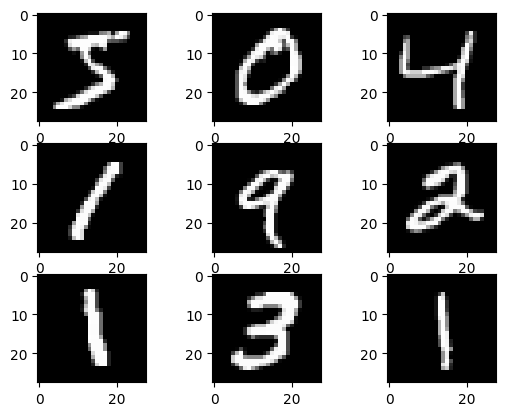

In [53]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

## Training the Classifier; model to attack and later defend

In [54]:
optimizer = tf.optimizers.Adam()

model = create_classifier()
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=["accuracy"])

model.fit(train_X, train_y)
model.save("classifier.h5")

Model: "mnist_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 13, 13, 28)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 5, 5, 56)         0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 3, 3, 56)          28280     
                                                                 
 flatten_13 (Flatten)        (None, 504)          

### Model baseline

In [55]:
model.evaluate(test_X, test_y)

313/313 [==============================] - 2s 6ms/step - loss: 0.0440 - accuracy: 0.9868


[0.044028379023075104, 0.9868000149726868]

## Defining models and input tensors

In [68]:
optimizer = tf.optimizers.Adam()

input = Input(shape=(28,28,1), name="image")

adv_generator = create_adv_generator()
adv_image = adv_generator(input)
adv_image = tf.clip_by_value(adv_image, 0, 1) # Values in image is [0,1]

perturbations = adv_image - input


# We want the generator and discriminator to be trained in a combined model but as seperate entities
discriminator = create_discriminator()
discriminator.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=["accuracy"])
discriminator.trainable = False
validity = discriminator(adv_image)

# We dont want to train our model to attack
model.trainable = False
prediction = model(adv_image)

# This is a targeted attack
target_prediction = Input(shape= (10,))
target_validity = Input(shape= (1,))
target_hinge_limit = Input(shape= (None, 28,28,1))

x = {
        "mnist_classifier": adv_image,
        "discriminator": adv_image,
        "adv_image_output": perturbations
    }

y = {
    "classication_output": target_prediction,
    "validity_output": target_validity,
    "adv_image_output": target_hinge_limit
    }

GAN_model = Model(inputs=adv_image, outputs=[prediction, validity, target_hinge_limit])

alpha = 2
beta = 1
c = 0

L_adv = CategoricalCrossentropy(from_logits=False)
L_GAN = BinaryCrossentropy(from_logits=False)
L_hinge = CategoricalCrossentropy()

losses = {
    "classication_output": L_adv,
    "validity_output": L_GAN,
    "adv_image_output": L_hinge,
}

losses_weights = {
    "classication_output": L_adv,
    "validity_output": alpha,
    "adv_image_output": beta,
}

GAN_model.compile(optimizer=optimizer, loss=losses, loss_weights=losses_weights, metrics=["accuracy"])
GAN_model.summary()

Model: "adv_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_116 (Conv2D)         (None, 28, 28, 28)        280       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 14, 14, 28)       0         
 g2D)                                                            
                                                                 
 conv2d_117 (Conv2D)         (None, 14, 14, 28)        7084      
                                                                 
 batch_normalization_32 (Bat  (None, 14, 14, 28)       112       
 chNormalization)                                                
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 14, 14, 28)        0         
                                                                 
 up_sampling2d_16 (UpSamplin  (None, 28, 28, 28)     

## AdvGAN Training

In [70]:
BATCH_SIZE = 32
EPOCHS = 1_000

y_real = np.ones((BATCH_SIZE, 1))
y_fake = np.zeros((BATCH_SIZE, 1))

# Targeted Attack
target_label = 0
target_prediction = np.zeros(10)
target_prediction[target_label] = 1
target_prediction = np.array([target_prediction]*BATCH_SIZE)

hinge_limit = np.full(shape=(BATCH_SIZE, 28,28,1), fill_value=c)

for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    x_real = np.array(random.choices(train_X, k=BATCH_SIZE))
    
    x_fake = adv_generator.predict(x_real)
    x_fake_prediction = model.predict(x_fake)
    x_fake_validity = discriminator.predict(x_fake)

    perturbations = x_fake - x_real

    discriminator.train_on_batch(x=x_real, y=y_real)
    discriminator.train_on_batch(x=x_fake, y=y_fake)

    x = {
        "mnist_classifier": x_fake,
        "discriminator": x_fake,
        "adv_image_output": perturbations
    }

    y = {
        "classication_output": target_prediction,
        "validity_output": y_fake,
        "adv_image_output": L_hinge
    }

    # GAN_model.train_on_batch(x=x, y=y, verbose=2)
    GAN_model.fit(x=x_fake, y=y, epochs=1, batch_size=BATCH_SIZE, verbose=2)

adv_generator.save("mnist_adv_generator.h5")
discriminator.save("mnist_adv_discriminator.h5")

EPOCH: 0
1/1 [==============================] - 0s 31ms/step


ValueError: Failed to find data adapter that can handle input: <class 'numpy.ndarray'>, (<class 'dict'> containing {"<class 'str'>"} keys and {"<class 'keras.losses.CategoricalCrossentropy'>", "<class 'numpy.ndarray'>"} values)

1/1 [==============================] - 0s 41ms/step
p = 0
p = 1
p = 1
p = 5
p = 6
p = 8
p = 9
p = 9
p = 4


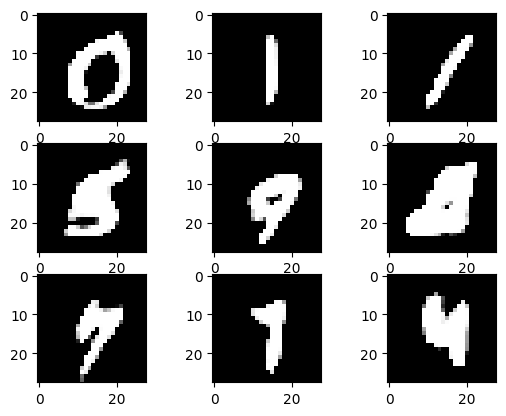

In [ ]:
x_real = np.array(random.choices(train_X, k=BATCH_SIZE))
x_fake = adv_generator.predict(x_real)
x_fake_labels = model.predict(x_fake)

for i in range(9):
    fig = plt.subplot(3, 3, i+1)
    plt.imshow(x_fake[i], cmap=plt.get_cmap('gray'))
    print(f'p = {np.argmax(x_fake_labels[i])}')
plt.show()